# Sokoban: A puzzle game of finding paths to push the boxes from the start position to the goal position (pink dots) on a 2 dimensional grid using a character. The area is cordoned by the brick walls, and players can move within the walls.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import networkx as nx
import queue

# Creating the Game State of Sokoban

In [2]:
import sys
import collections
import numpy as np
import heapq
import time

class PriorityQueue:
    """Define a PriorityQueue data structure that will be used"""
    def  __init__(self):
        self.Heap = []
        self.Count = 0

    def push(self, item, priority):
        entry = (priority, self.Count, item)
        heapq.heappush(self.Heap, entry)
        self.Count += 1

    def pop(self):
        (_, _, item) = heapq.heappop(self.Heap)
        return item

    def isEmpty(self):
        return len(self.Heap) == 0

"""Load puzzles and define the rules of sokoban"""

def transferToGameState(layout):
    """Transfer the layout of initial puzzle"""
    layout = [x.replace('\n','') for x in layout]
    layout = [','.join(layout[i]) for i in range(len(layout))]
    layout = [x.split(',') for x in layout]
    maxColsNum = max([len(x) for x in layout])
    for irow in range(len(layout)):
        for icol in range(len(layout[irow])):
            if layout[irow][icol] == ' ': layout[irow][icol] = 0   # free space
            elif layout[irow][icol] == '#': layout[irow][icol] = 1 # wall
            elif layout[irow][icol] == '&': layout[irow][icol] = 2 # player
            elif layout[irow][icol] == 'B': layout[irow][icol] = 3 # box
            elif layout[irow][icol] == '.': layout[irow][icol] = 4 # goal
            elif layout[irow][icol] == 'X': layout[irow][icol] = 5 # box on goal
        colsNum = len(layout[irow])
        if colsNum < maxColsNum:
            layout[irow].extend([1 for _ in range(maxColsNum-colsNum)]) 
    return np.array(layout)

def PosOfPlayer(gameState):
    """Return the position of agent"""
    return tuple(np.argwhere(gameState == 2)[0]) # e.g. (2, 2)

def PosOfBoxes(gameState):
    """Return the positions of boxes"""
    return tuple(tuple(x) for x in np.argwhere((gameState == 3) | (gameState == 5))) # e.g. ((2, 3), (3, 4), (4, 4), (6, 1), (6, 4), (6, 5))

def PosOfWalls(gameState):
    """Return the positions of walls"""
    return tuple(tuple(x) for x in np.argwhere(gameState == 1)) # e.g. like those above

def PosOfGoals(gameState):
    """Return the positions of goals"""
    return tuple(tuple(x) for x in np.argwhere((gameState == 4) | (gameState == 5))) # e.g. like those above

def isEndState(posBox):
    """Check if all boxes are on the goals (i.e. pass the game)"""
    return sorted(posBox) == sorted(posGoals)

def isLegalAction(action, posPlayer, posBox):
    """Check if the given action is legal"""
    xPlayer, yPlayer = posPlayer
    if action[-1].isupper(): # the move was a push
        x1, y1 = xPlayer + 2 * action[0], yPlayer + 2 * action[1]
    else:
        x1, y1 = xPlayer + action[0], yPlayer + action[1]
    return (x1, y1) not in posBox + posWalls

def legalActions(posPlayer, posBox):
    """Return all legal actions for the agent in the current game state"""
    allActions = [[-1,0,'u','U'],[1,0,'d','D'],[0,-1,'l','L'],[0,1,'r','R']]
    xPlayer, yPlayer = posPlayer
    legalActions = []
    for action in allActions:
        x1, y1 = xPlayer + action[0], yPlayer + action[1]
        if (x1, y1) in posBox: # the move was a push
            action.pop(2) # drop the little letter
        else:
            action.pop(3) # drop the upper letter
        if isLegalAction(action, posPlayer, posBox):
            legalActions.append(action)
        else: 
            continue     
    return tuple(tuple(x) for x in legalActions) # e.g. ((0, -1, 'l'), (0, 1, 'R'))

def updateState(posPlayer, posBox, action):
    """Return updated game state after an action is taken"""
    xPlayer, yPlayer = posPlayer # the previous position of player
    newPosPlayer = [xPlayer + action[0], yPlayer + action[1]] # the current position of player
    posBox = [list(x) for x in posBox]
    if action[-1].isupper(): # if pushing, update the position of box
        posBox.remove(newPosPlayer)
        posBox.append([xPlayer + 2 * action[0], yPlayer + 2 * action[1]])
    posBox = tuple(tuple(x) for x in posBox)
    newPosPlayer = tuple(newPosPlayer)
    return newPosPlayer, posBox

def isFailed(posBox):
    """This function used to observe if the state is potentially failed, then prune the search"""
    rotatePattern = [[0,1,2,3,4,5,6,7,8],
                    [2,5,8,1,4,7,0,3,6],
                    [0,1,2,3,4,5,6,7,8][::-1],
                    [2,5,8,1,4,7,0,3,6][::-1]]
    flipPattern = [[2,1,0,5,4,3,8,7,6],
                    [0,3,6,1,4,7,2,5,8],
                    [2,1,0,5,4,3,8,7,6][::-1],
                    [0,3,6,1,4,7,2,5,8][::-1]]
    allPattern = rotatePattern + flipPattern

    for box in posBox:
        if box not in posGoals:
            board = [(box[0] - 1, box[1] - 1), (box[0] - 1, box[1]), (box[0] - 1, box[1] + 1), 
                    (box[0], box[1] - 1), (box[0], box[1]), (box[0], box[1] + 1), 
                    (box[0] + 1, box[1] - 1), (box[0] + 1, box[1]), (box[0] + 1, box[1] + 1)]
            for pattern in allPattern:
                newBoard = [board[i] for i in pattern]
                if newBoard[1] in posWalls and newBoard[5] in posWalls: return True
                elif newBoard[1] in posBox and newBoard[2] in posWalls and newBoard[5] in posWalls: return True
                elif newBoard[1] in posBox and newBoard[2] in posWalls and newBoard[5] in posBox: return True
                elif newBoard[1] in posBox and newBoard[2] in posBox and newBoard[5] in posBox: return True
                elif newBoard[1] in posBox and newBoard[6] in posBox and newBoard[2] in posWalls and newBoard[3] in posWalls and newBoard[8] in posWalls: return True
    return False

layout = """
#######
###   #
#.&B  #
### B.# 
#.##B # 
# # . ## 
#B XBB.#
#   .  #
########
"""

gameState = transferToGameState(layout.split('\n'))
gameState = gameState[1:-1, :]
print(gameState)


[['1' '1' '1' '1' '1' '1' '1' '1' '1']
 ['1' '1' '1' '0' '0' '0' '1' '1' '1']
 ['1' '4' '2' '3' '0' '0' '1' '1' '1']
 ['1' '1' '1' '0' '3' '4' '1' '0' '1']
 ['1' '4' '1' '1' '3' '0' '1' '0' '1']
 ['1' '0' '1' '0' '4' '0' '1' '1' '0']
 ['1' '3' '0' '5' '3' '3' '4' '1' '1']
 ['1' '0' '0' '0' '4' '0' '0' '1' '1']
 ['1' '1' '1' '1' '1' '1' '1' '1' '1']]


# Converting the Sokoban to a Graph

In [3]:
class MazeGraph(object):
    ''' Class to represent a Graph
        Construction: Using Edges
    '''
    def __init__(self):
        self.edges = {}

    def all_edges(self):
        return self.edges

    def neighbors(self, node):
        return self.edges[node]

    def add_edge(self, node1, node2):
        if node1 not in self.edges:
            self.edges[node1] = []
        self.edges[node1].append(node2)

In [4]:
# Define the MazeGraph class
class MazeGraph(object):
    ''' Class to represent a Graph
        Construction: Using Edges
    '''
    def __init__(self):
        self.edges = {}

    def all_edges(self):
        return self.edges

    def neighbors(self, node):
        return self.edges[node]

    def add_edge(self, node1, node2):
        if node1 not in self.edges:
            self.edges[node1] = []
        self.edges[node1].append(node2)

# Convert the maze to a graph
def maze_to_graph(maze):
    graph = MazeGraph()
    height, width = len(maze), len(maze[0])

    # Define helper function to check if a cell is valid
    def is_valid_cell(row, col):
        return 0 <= row < height and 0 <= col < width and maze[row][col] != '1'

    # Iterate through each cell in the maze
    for row in range(height):
        for col in range(width):
            if maze[row][col] != '1':  # If cell is not a wall
                neighbors = []

                # Check neighboring cells (up, down, left, right)
                directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
                for dr, dc in directions:
                    new_row, new_col = row + dr, col + dc
                    if is_valid_cell(new_row, new_col):
                        neighbors.append((new_row, new_col))

                # Add edges to the graph
                graph.add_edge((row, col), neighbors)

    return graph

# Example usage:
maze = [['1', '1', '1', '1', '1', '1', '1', '1', '1'],
        ['1', '1', '1', '0', '0', '0', '1', '1', '1'],
        ['1', '4', '2', '3', '0', '0', '1', '1', '1'],
        ['1', '1', '1', '0', '3', '4', '1', '0', '1'],
        ['1', '4', '1', '1', '3', '0', '1', '0', '1'],
        ['1', '0', '1', '0', '4', '0', '1', '1', '0'],
        ['1', '3', '0', '5', '3', '3', '4', '1', '1'],
        ['1', '0', '0', '0', '4', '0', '0', '1', '1'],
        ['1', '1', '1', '1', '1', '1', '1', '1', '1']]



graph = maze_to_graph(maze)
print(graph.all_edges())


{(1, 3): [[(2, 3), (1, 4)]], (1, 4): [[(2, 4), (1, 3), (1, 5)]], (1, 5): [[(2, 5), (1, 4)]], (2, 1): [[(2, 2)]], (2, 2): [[(2, 1), (2, 3)]], (2, 3): [[(1, 3), (3, 3), (2, 2), (2, 4)]], (2, 4): [[(1, 4), (3, 4), (2, 3), (2, 5)]], (2, 5): [[(1, 5), (3, 5), (2, 4)]], (3, 3): [[(2, 3), (3, 4)]], (3, 4): [[(2, 4), (4, 4), (3, 3), (3, 5)]], (3, 5): [[(2, 5), (4, 5), (3, 4)]], (3, 7): [[(4, 7)]], (4, 1): [[(5, 1)]], (4, 4): [[(3, 4), (5, 4), (4, 5)]], (4, 5): [[(3, 5), (5, 5), (4, 4)]], (4, 7): [[(3, 7)]], (5, 1): [[(4, 1), (6, 1)]], (5, 3): [[(6, 3), (5, 4)]], (5, 4): [[(4, 4), (6, 4), (5, 3), (5, 5)]], (5, 5): [[(4, 5), (6, 5), (5, 4)]], (5, 8): [[]], (6, 1): [[(5, 1), (7, 1), (6, 2)]], (6, 2): [[(7, 2), (6, 1), (6, 3)]], (6, 3): [[(5, 3), (7, 3), (6, 2), (6, 4)]], (6, 4): [[(5, 4), (7, 4), (6, 3), (6, 5)]], (6, 5): [[(5, 5), (7, 5), (6, 4), (6, 6)]], (6, 6): [[(7, 6), (6, 5)]], (7, 1): [[(6, 1), (7, 2)]], (7, 2): [[(6, 2), (7, 1), (7, 3)]], (7, 3): [[(6, 3), (7, 2), (7, 4)]], (7, 4): [[(6,

In [5]:
# Display the graph
def display_graph(graph):
    for node, neighbors in graph.all_edges().items():
        print(f"{node} -> {neighbors}")

graph = maze_to_graph(maze)
display_graph(graph)

(1, 3) -> [[(2, 3), (1, 4)]]
(1, 4) -> [[(2, 4), (1, 3), (1, 5)]]
(1, 5) -> [[(2, 5), (1, 4)]]
(2, 1) -> [[(2, 2)]]
(2, 2) -> [[(2, 1), (2, 3)]]
(2, 3) -> [[(1, 3), (3, 3), (2, 2), (2, 4)]]
(2, 4) -> [[(1, 4), (3, 4), (2, 3), (2, 5)]]
(2, 5) -> [[(1, 5), (3, 5), (2, 4)]]
(3, 3) -> [[(2, 3), (3, 4)]]
(3, 4) -> [[(2, 4), (4, 4), (3, 3), (3, 5)]]
(3, 5) -> [[(2, 5), (4, 5), (3, 4)]]
(3, 7) -> [[(4, 7)]]
(4, 1) -> [[(5, 1)]]
(4, 4) -> [[(3, 4), (5, 4), (4, 5)]]
(4, 5) -> [[(3, 5), (5, 5), (4, 4)]]
(4, 7) -> [[(3, 7)]]
(5, 1) -> [[(4, 1), (6, 1)]]
(5, 3) -> [[(6, 3), (5, 4)]]
(5, 4) -> [[(4, 4), (6, 4), (5, 3), (5, 5)]]
(5, 5) -> [[(4, 5), (6, 5), (5, 4)]]
(5, 8) -> [[]]
(6, 1) -> [[(5, 1), (7, 1), (6, 2)]]
(6, 2) -> [[(7, 2), (6, 1), (6, 3)]]
(6, 3) -> [[(5, 3), (7, 3), (6, 2), (6, 4)]]
(6, 4) -> [[(5, 4), (7, 4), (6, 3), (6, 5)]]
(6, 5) -> [[(5, 5), (7, 5), (6, 4), (6, 6)]]
(6, 6) -> [[(7, 6), (6, 5)]]
(7, 1) -> [[(6, 1), (7, 2)]]
(7, 2) -> [[(6, 2), (7, 1), (7, 3)]]
(7, 3) -> [[(6, 3), (

In [6]:
# Helper functions to display a Graph

def showBinaryMazeGraph(mazeGraph):
    ''' Display a graph using networkx
        Input : MazeGraph from 2D maze
        Output : Input graph displayed
    '''
    edgeDict = mazeGraph.all_edges()
    edgeList = []
    for node in edgeDict:
        for neighbor, weight in edgeDict[node]:
            edgeList.append((node,neighbor, {'weight': weight}))

    G = nx.Graph()
    G.add_edges_from(edgeList)

    f = plt.figure(figsize = (40,40))
    pos = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size = 2000)
    nx.draw_networkx_edges(G, pos, width = 2)
    nx.draw_networkx_labels(G, pos, font_size = 10)

    plt.axis("off")
    plt.show()


# Displaying the Sokoban Graph

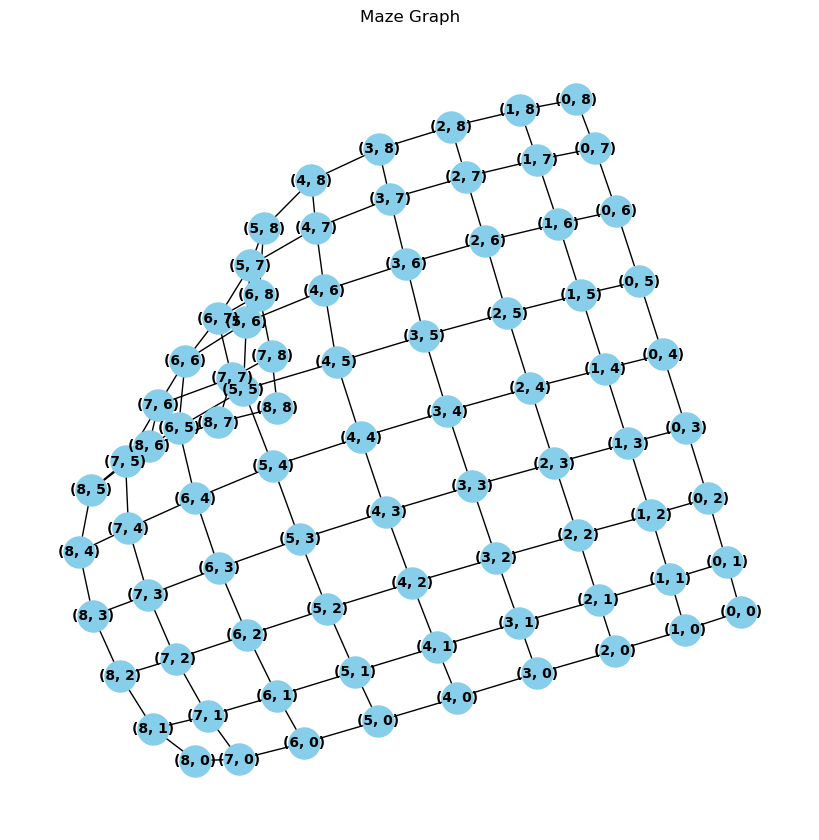

In [21]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the MazeGraph class
class MazeGraph:
    def __init__(self, maze):
        self.edges = self.generate_edges(maze)

    def generate_edges(self, maze):
        edges = {}
        rows, cols = len(maze), len(maze[0])
        for i in range(rows):
            for j in range(cols):
                if maze[i][j] != 1:  # Ignore walls
                    node = (i, j)
                    neighbors = []
                    # Check neighboring cells
                    if i > 0 and maze[i - 1][j] != 1:
                        neighbors.append(((i - 1, j), 1))  # Assuming unit cost for edges
                    if i < rows - 1 and maze[i + 1][j] != 1:
                        neighbors.append(((i + 1, j), 1))
                    if j > 0 and maze[i][j - 1] != 1:
                        neighbors.append(((i, j - 1), 1))
                    if j < cols - 1 and maze[i][j + 1] != 1:
                        neighbors.append(((i, j + 1), 1))
                    edges[node] = neighbors
        return edges

    def all_edges(self):
        return self.edges

# Define the function to display the graph
def showBinaryMazeGraph(mazeGraph):
    ''' Display a graph using networkx
        Input : MazeGraph from 2D maze
        Output : Input graph displayed
    '''
    edgeDict = mazeGraph.all_edges()
    edgeList = []

    # Flatten the edge dictionary into a list of edges
    for node, neighbors in edgeDict.items():
        for neighbor, weight in neighbors:
            edgeList.append((node, neighbor, {'weight': weight}))

    # Create a directed graph
    G = nx.Graph()
    G.add_edges_from(edgeList)

    # Draw the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Layout the nodes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', arrows=True, arrowsize=20)
    plt.title('Maze Graph')
    plt.show()

# Define the maze
maze = [['1', '1', '1', '1', '1', '1', '1', '1', '1'],
        ['1', '1', '1', '0', '0', '0', '1', '1', '1'],
        ['1', '4', '2', '3', '0', '0', '1', '1', '1'],
        ['1', '1', '1', '0', '3', '4', '1', '0', '1'],
        ['1', '4', '1', '1', '3', '0', '1', '0', '1'],
        ['1', '0', '1', '0', '4', '0', '1', '1', '0'],
        ['1', '3', '0', '5', '3', '3', '4', '1', '1'],
        ['1', '0', '0', '0', '4', '0', '0', '1', '1'],
        ['1', '1', '1', '1', '1', '1', '1', '1', '1']]






# Create a MazeGraph instance
mazeGraph = MazeGraph(maze)

# Display the maze graph
showBinaryMazeGraph(mazeGraph)


# Breadth First Search (BFS)

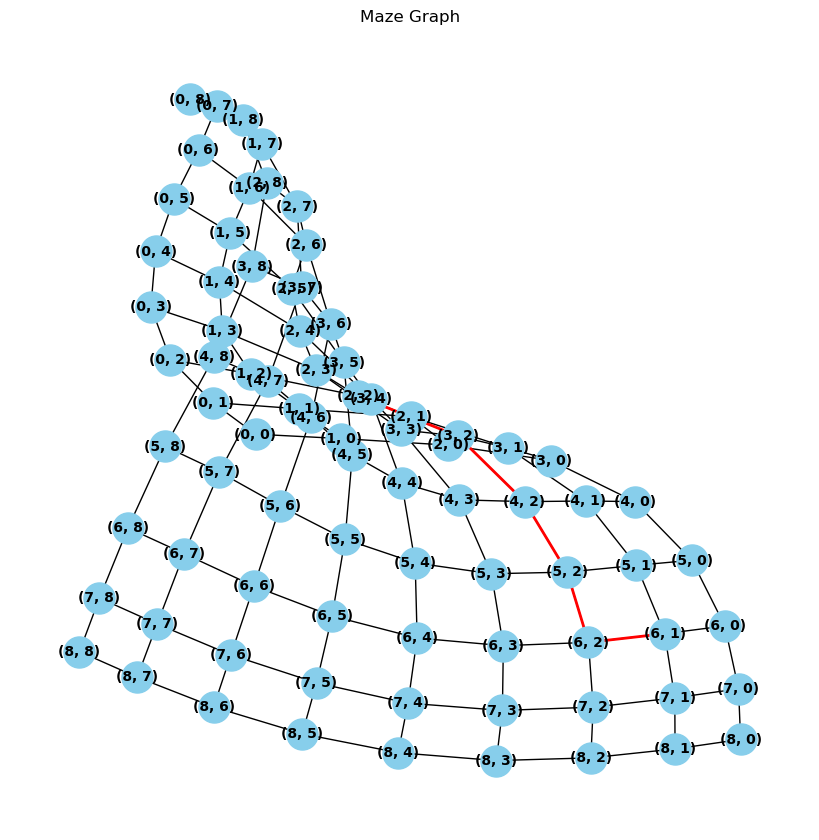

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the MazeGraph class
class MazeGraph:
    def __init__(self, maze):
        self.edges = self.generate_edges(maze)

    def generate_edges(self, maze):
        edges = {}
        rows, cols = len(maze), len(maze[0])
        for i in range(rows):
            for j in range(cols):
                if maze[i][j] != '1':  # Ignore walls
                    node = (i, j)
                    neighbors = []
                    # Check neighboring cells
                    if i > 0 and maze[i - 1][j] != '1':
                        neighbors.append(((i - 1, j), 1))  # Assuming unit cost for edges
                    if i < rows - 1 and maze[i + 1][j] != '1':
                        neighbors.append(((i + 1, j), 1))
                    if j > 0 and maze[i][j - 1] != '1':
                        neighbors.append(((i, j - 1), 1))
                    if j < cols - 1 and maze[i][j + 1] != '1':
                        neighbors.append(((i, j + 1), 1))
                    edges[node] = neighbors
        return edges

    def all_edges(self):
        return self.edges

# Define the function to display the graph
def showBinaryMazeGraph(mazeGraph, path=None):
    ''' Display a graph using networkx
        Input : MazeGraph from 2D maze, path (optional) - list of nodes representing the path
        Output : Input graph displayed
    '''
    edgeDict = mazeGraph.all_edges()
    edgeList = []

    # Flatten the edge dictionary into a list of edges
    for node, neighbors in edgeDict.items():
        for neighbor, weight in neighbors:
            edgeList.append((node, neighbor, {'weight': weight}))

    # Create a directed graph
    G = nx.Graph()
    G.add_edges_from(edgeList)

    # Draw the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Layout the nodes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)

    # Highlight the path if provided
    if path:
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.title('Maze Graph')
    plt.show()

# Function for BFS
def bfs(graph, start, goal):
    queue = [(start, [])]  # Initialize the queue with the start node and an empty path
    while queue:
        (node, path) = queue.pop(0)
        if node == goal:
            return path + [node]  # Return the complete path when the goal is reached
        for next_node, _ in graph.get(node, []):
            if next_node not in path:
                queue.append((next_node, path + [node]))  # Update the path with the current node
    return None

# Define the maze
maze = [['1', '1', '1', '1', '1', '1', '1', '1', '1'],
        ['1', '1', '1', '0', '0', '0', '1', '1', '1'],
        ['1', '4', '2', '3', '0', '0', '1', '1', '1'],
        ['1', '1', '1', '0', '3', '4', '1', '0', '1'],
        ['1', '4', '1', '1', '3', '0', '1', '0', '1'],
        ['1', '0', '1', '0', '4', '0', '1', '1', '0'],
        ['1', '3', '0', '5', '3', '3', '4', '1', '1'],
        ['1', '0', '0', '0', '4', '0', '0', '1', '1'],
        ['1', '1', '1', '1', '1', '1', '1', '1', '1']]

# Convert maze to integers
maze = [[int(cell) for cell in row] for row in maze]

# Find the starting position
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 2:
            start_node = (i, j)
            break

# Find the goal position
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 3:
            goal_node = (i, j)
            break

# Create a MazeGraph instance
mazeGraph = MazeGraph(maze)

# Perform BFS from start to goal
path = bfs(mazeGraph.edges, start_node, goal_node)

# Display the maze graph with BFS path
showBinaryMazeGraph(mazeGraph, path)


In [9]:
def calculate_path_cost(path):
    # The cost of the path is the number of nodes visited (assuming unit cost for edges)
    return len(path)

# Calculate the cost of the BFS path
cost_of_path = calculate_path_cost(path)
print("Cost of the path obtained from Breadth-First Search:", cost_of_path)


Cost of the path obtained from Breadth-First Search: 6


# Depth First Search (DFS)

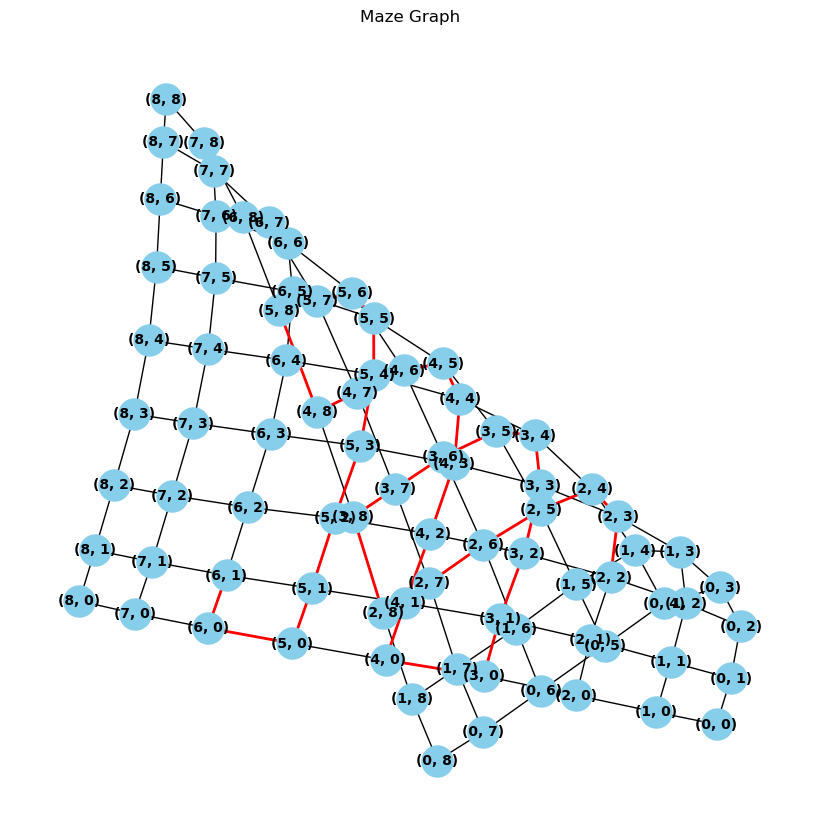

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the MazeGraph class
class MazeGraph:
    def __init__(self, maze):
        self.edges = self.generate_edges(maze)

    def generate_edges(self, maze):
        edges = {}
        rows, cols = len(maze), len(maze[0])
        for i in range(rows):
            for j in range(cols):
                if maze[i][j] != '1':  # Ignore walls
                    node = (i, j)
                    neighbors = []
                    # Check neighboring cells
                    if i > 0 and maze[i - 1][j] != '1':
                        neighbors.append(((i - 1, j), 1))  # Assuming unit cost for edges
                    if i < rows - 1 and maze[i + 1][j] != '1':
                        neighbors.append(((i + 1, j), 1))
                    if j > 0 and maze[i][j - 1] != '1':
                        neighbors.append(((i, j - 1), 1))
                    if j < cols - 1 and maze[i][j + 1] != '1':
                        neighbors.append(((i, j + 1), 1))
                    edges[node] = neighbors
        return edges

    def all_edges(self):
        return self.edges

# Define the function to display the graph
def showBinaryMazeGraph(mazeGraph, path=None):
    ''' Display a graph using networkx
        Input : MazeGraph from 2D maze, path (optional) - list of nodes representing the path
        Output : Input graph displayed
    '''
    edgeDict = mazeGraph.all_edges()
    edgeList = []

    # Flatten the edge dictionary into a list of edges
    for node, neighbors in edgeDict.items():
        for neighbor, weight in neighbors:
            edgeList.append((node, neighbor, {'weight': weight}))

    # Create a directed graph
    G = nx.Graph()
    G.add_edges_from(edgeList)

    # Draw the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Layout the nodes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)

    # Highlight the path if provided
    if path:
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.title('Maze Graph')
    plt.show()

# Function for DFS
def dfs(graph, start, goal):
    stack = [(start, [])]  # Initialize the stack with the start node and an empty path
    while stack:
        (node, path) = stack.pop()
        if node == goal:
            return path + [node]  # Return the complete path when the goal is reached
        for next_node, _ in graph.get(node, []):
            if next_node not in path:
                stack.append((next_node, path + [node]))  # Update the path with the current node
    return None


# Define the maze
maze = [['1', '1', '1', '1', '1', '1', '1', '1', '1'],
        ['1', '1', '1', '0', '0', '0', '1', '1', '1'],
        ['1', '4', '2', '3', '0', '0', '1', '1', '1'],
        ['1', '1', '1', '0', '3', '4', '1', '0', '1'],
        ['1', '4', '1', '1', '3', '0', '1', '0', '1'],
        ['1', '0', '1', '0', '4', '0', '1', '1', '0'],
        ['1', '3', '0', '5', '3', '3', '4', '1', '1'],
        ['1', '0', '0', '0', '4', '0', '0', '1', '1'],
        ['1', '1', '1', '1', '1', '1', '1', '1', '1']]
# Convert maze to integers
maze = [[int(cell) for cell in row] for row in maze]

# Find the starting position
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 2:
            start_node = (i, j)
            break

# Find the goal position
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 3:
            goal_node = (i, j)
            break

# Create a MazeGraph instance
mazeGraph = MazeGraph(maze)

# Perform BFS from start to goal
path = dfs(mazeGraph.edges, start_node, goal_node)

# Display the maze graph with BFS path
showBinaryMazeGraph(mazeGraph, path)



In [11]:
def calculate_path_cost(path):
    # The cost of the path is the number of nodes visited (assuming unit cost for edges)
    return len(path)

# Calculate the cost of the DFS path
cost_of_path = calculate_path_cost(path)
print("Cost of the path obtained from Depth-First Search:", cost_of_path)


Cost of the path obtained from Depth-First Search: 36


# Depth Limited Search

Visiting node: (1, 1)
Computed Path: None


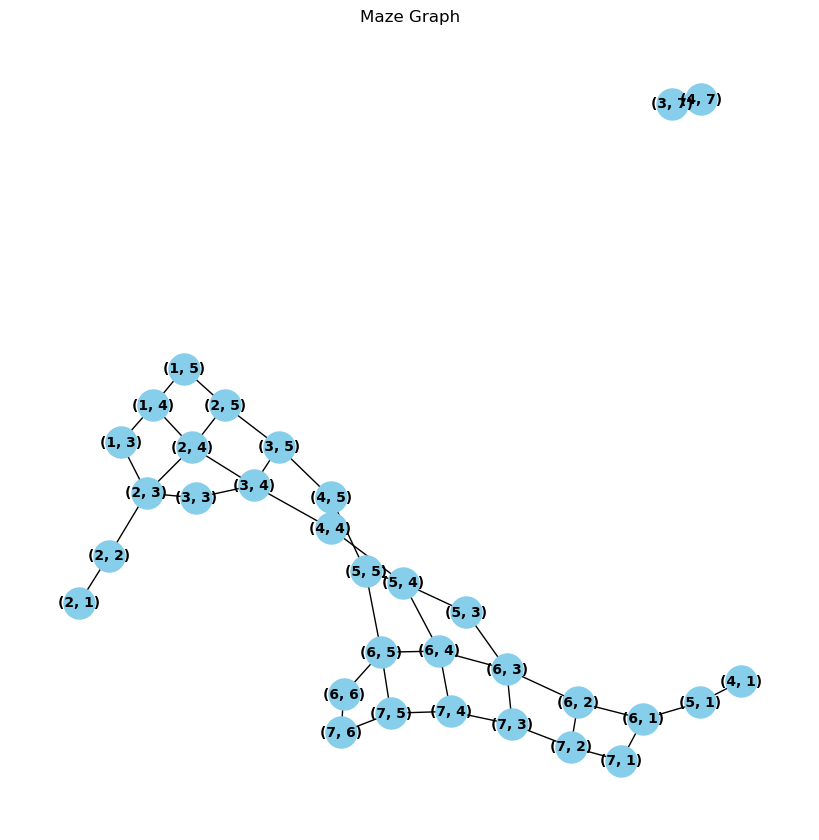

In [12]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the MazeGraph class
class MazeGraph:
    def __init__(self, maze):
        self.edges = self.generate_edges(maze)

    def generate_edges(self, maze):
        edges = {}
        rows, cols = len(maze), len(maze[0])
        for i in range(rows):
            for j in range(cols):
                if maze[i][j] != 1:  # Ignore walls
                    node = (i, j)
                    neighbors = []
                    # Check neighboring cells
                    if i > 0 and maze[i - 1][j] != 1:
                        neighbors.append(((i - 1, j), 1))  # Assuming unit cost for edges
                    if i < rows - 1 and maze[i + 1][j] != 1:
                        neighbors.append(((i + 1, j), 1))
                    if j > 0 and maze[i][j - 1] != 1:
                        neighbors.append(((i, j - 1), 1))
                    if j < cols - 1 and maze[i][j + 1] != 1:
                        neighbors.append(((i, j + 1), 1))
                    edges[node] = neighbors
        return edges

    def all_edges(self):
        return self.edges

# Define the function to display the graph
def showBinaryMazeGraph(mazeGraph, path=None):
    ''' Display a graph using networkx
        Input : MazeGraph from 2D maze, path (optional) - list of nodes representing the path
        Output : Input graph displayed
    '''
    edgeDict = mazeGraph.all_edges()
    edgeList = []

    # Flatten the edge dictionary into a list of edges
    for node, neighbors in edgeDict.items():
        for neighbor, weight in neighbors:
            edgeList.append((node, neighbor, {'weight': weight}))

    # Create a directed graph
    G = nx.Graph()
    G.add_edges_from(edgeList)

    # Draw the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Layout the nodes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)

    # Highlight the path if provided
    if path:
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.title('Maze Graph')
    plt.show()

# Function for Depth-Limited Search
def dls(graph, start, goal, depth_limit):
    stack = [(start, [start], 0)]
    visited = set()  # Track visited nodes
    while stack:
        (node, path, depth) = stack.pop()
        print("Visiting node:", node)
        if node == goal:
            return path
        if depth < depth_limit:
            for next_node, _ in graph.get(node, []):
                if next_node not in visited:
                    print("Adding next node to stack:", next_node)
                    stack.append((next_node, path + [next_node], depth + 1))
                    visited.add(next_node)  # Mark the node as visited
    return None



# Define the maze
maze = [[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1],
        [1, 4, 2, 3, 0, 0, 1, 1, 1],
        [1, 1, 1, 0, 3, 4, 1, 0, 1],
        [1, 4, 1, 1, 3, 0, 1, 0, 1],
        [1, 0, 1, 0, 4, 0, 1, 1, 0],
        [1, 3, 0, 5, 3, 3, 4, 1, 1],
        [1, 0, 0, 0, 4, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]]

# Create a MazeGraph instance
mazeGraph = MazeGraph(maze)

# Perform Depth-Limited Search from start to goal with depth limit of 5
start_node = (1, 1)  # Starting position
goal_node = (4, 2)   # Goal position
depth_limit = 30
path = dls(mazeGraph.edges, start_node, goal_node, depth_limit)

print("Computed Path:", path)


# Display the maze graph with Depth-Limited Search path
showBinaryMazeGraph(mazeGraph, path)


# Iterative Deepening 

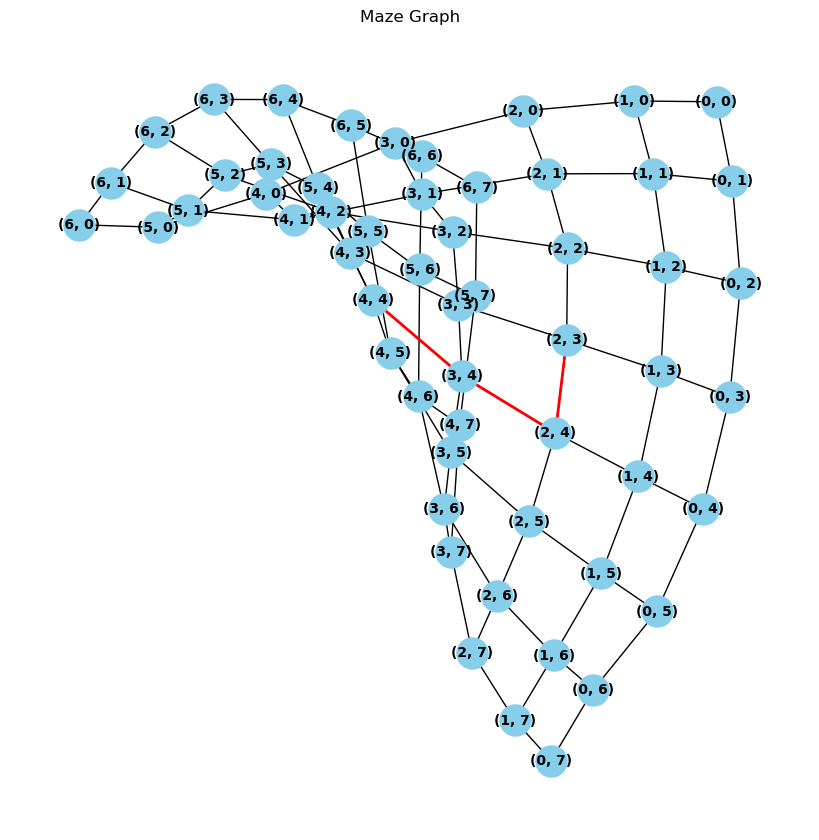

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the MazeGraph class
class MazeGraph:
    def __init__(self, maze):
        self.edges = self.generate_edges(maze)

    def generate_edges(self, maze):
        edges = {}
        rows, cols = len(maze), len(maze[0])
        for i in range(rows):
            for j in range(cols):
                if maze[i][j] != '1':  # Ignore walls
                    node = (i, j)
                    neighbors = []
                    # Check neighboring cells
                    if i > 0 and maze[i - 1][j] != '1':
                        neighbors.append(((i - 1, j), 1))  # Assuming unit cost for edges
                    if i < rows - 1 and maze[i + 1][j] != '1':
                        neighbors.append(((i + 1, j), 1))
                    if j > 0 and maze[i][j - 1] != '1':
                        neighbors.append(((i, j - 1), 1))
                    if j < cols - 1 and maze[i][j + 1] != '1':
                        neighbors.append(((i, j + 1), 1))
                    edges[node] = neighbors
        return edges

    def all_edges(self):
        return self.edges

# Define the function to display the graph
def showBinaryMazeGraph(mazeGraph, path=None):
    ''' Display a graph using networkx
        Input : MazeGraph from 2D maze, path (optional) - list of nodes representing the path
        Output : Input graph displayed
    '''
    edgeDict = mazeGraph.all_edges()
    edgeList = []

    # Flatten the edge dictionary into a list of edges
    for node, neighbors in edgeDict.items():
        for neighbor, weight in neighbors:
            edgeList.append((node, neighbor, {'weight': weight}))

    # Create a directed graph
    G = nx.Graph()
    G.add_edges_from(edgeList)

    # Draw the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Layout the nodes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)

    # Highlight the path if provided
    if path:
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.title('Maze Graph')
    plt.show()

# Function for Depth-Limited Search
def dls(graph, start, goal, depth_limit):
    stack = [(start, [start], 0)]
    while stack:
        (node, path, depth) = stack.pop()
        if node == goal:
            return path
        if depth < depth_limit:
            for next_node, _ in graph[node]:
                if next_node not in path:
                    stack.append((next_node, path + [next_node], depth + 1))
    return None

# Function for Iterative Deepening Search
def iterative_deepening_search(graph, start, goal):
    depth_limit = 0
    while True:
        result = dls(graph, start, goal, depth_limit)
        if result is not None:
            return result
        depth_limit += 1

# Define the maze
maze = [['1', '1', '1', '1', '1', '1', '1', '1'],
        ['1', '4', '4', '4', '0', '1', '1', '1'],
        ['1', '0', '3', '2', '3', '0', '1', '1'],
        ['1', '1', '0', '1', '1', '0', '0', '1'],
        ['0', '1', '0', '0', '3', '0', '0', '1'],
        ['0', '1', '0', '0', '1', '0', '0', '1'],
        ['0', '1', '1', '1', '1', '1', '1', '1']]


# Convert maze to integers
maze = [[int(cell) for cell in row] for row in maze]

# Find the starting position
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 2:
            start_node = (i, j)
            break

# Find the goal position
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 3:
            goal_node = (i, j)
            break

# Create a MazeGraph instance
mazeGraph = MazeGraph(maze)

# Perform BFS from start to goal
path = iterative_deepening_search(mazeGraph.edges, start_node, goal_node)

# Display the maze graph with BFS path
showBinaryMazeGraph(mazeGraph, path)


In [14]:
def calculate_path_cost(path, graph):
    total_cost = 0
    for i in range(len(path) - 1):
        current_node = path[i]
        next_node = path[i + 1]
        for neighbor, edge_cost in graph[current_node]:
            if neighbor == next_node:
                total_cost += edge_cost
                break
    return total_cost

# Calculate the cost of the IDS path
cost_of_path = calculate_path_cost(path, mazeGraph.edges)
print("Cost of the path obtained from Iterative Deepening Search:", cost_of_path)


Cost of the path obtained from Iterative Deepening Search: 3


# Uniform-cost Search

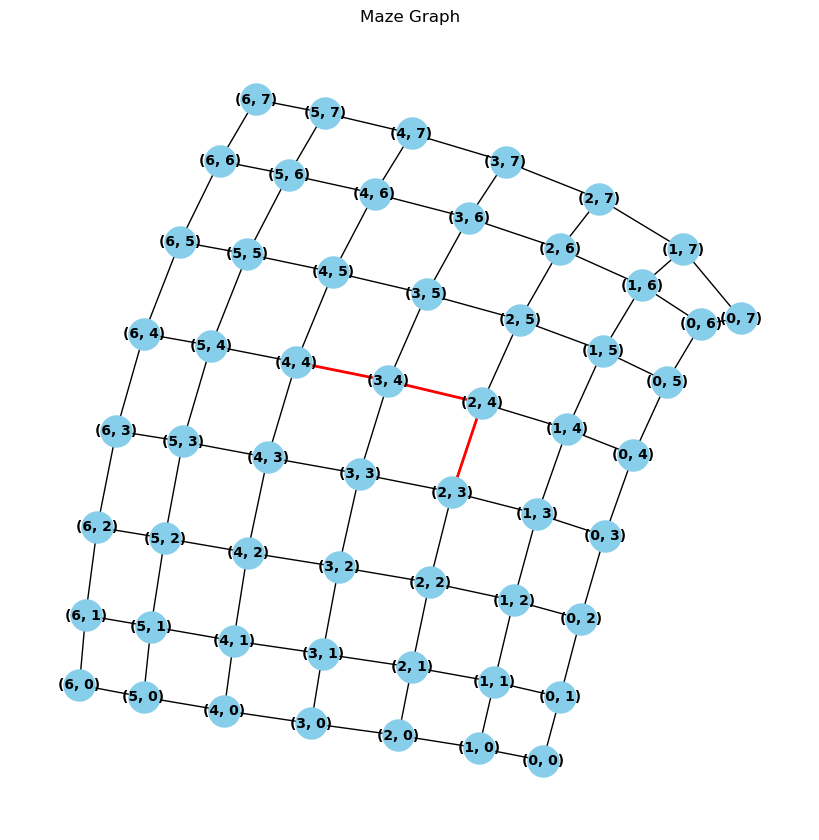

In [15]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the MazeGraph class
class MazeGraph:
    def __init__(self, maze):
        self.edges = self.generate_edges(maze)

    def generate_edges(self, maze):
        edges = {}
        rows, cols = len(maze), len(maze[0])
        for i in range(rows):
            for j in range(cols):
                if maze[i][j] != '1':  # Ignore walls
                    node = (i, j)
                    neighbors = []
                    # Check neighboring cells
                    if i > 0 and maze[i - 1][j] != '1':
                        neighbors.append(((i - 1, j), 1))  # Assuming unit cost for edges
                    if i < rows - 1 and maze[i + 1][j] != '1':
                        neighbors.append(((i + 1, j), 1))
                    if j > 0 and maze[i][j - 1] != '1':
                        neighbors.append(((i, j - 1), 1))
                    if j < cols - 1 and maze[i][j + 1] != '1':
                        neighbors.append(((i, j + 1), 1))
                    edges[node] = neighbors
        return edges

    def all_edges(self):
        return self.edges

# Define the function to display the graph
def showBinaryMazeGraph(mazeGraph, path=None):
    ''' Display a graph using networkx
        Input : MazeGraph from 2D maze, path (optional) - list of nodes representing the path
        Output : Input graph displayed
    '''
    edgeDict = mazeGraph.all_edges()
    edgeList = []

    # Flatten the edge dictionary into a list of edges
    for node, neighbors in edgeDict.items():
        for neighbor, weight in neighbors:
            edgeList.append((node, neighbor, {'weight': weight}))

    # Create a directed graph
    G = nx.Graph()
    G.add_edges_from(edgeList)

    # Draw the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Layout the nodes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)

    # Highlight the path if provided
    if path:
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.title('Maze Graph')
    plt.show()

# Function for UCS
def ucs(graph, start, goal):
    queue = [(0, start, [start])]
    while queue:
        (cost, node, path) = queue.pop(0)
        if node == goal:
            return path
        for next_node, weight in graph[node]:
            if next_node not in path:
                new_cost = cost + weight
                new_path = path + [next_node]
                queue.append((new_cost, next_node, new_path))
                # Sort the queue based on cost
                queue.sort()
    return None

# Define the maze
maze = [['1', '1', '1', '1', '1', '1', '1', '1'],
        ['1', '4', '4', '4', '0', '1', '1', '1'],
        ['1', '0', '3', '2', '3', '0', '1', '1'],
        ['1', '1', '0', '1', '1', '0', '0', '1'],
        ['0', '1', '0', '0', '3', '0', '0', '1'],
        ['0', '1', '0', '0', '1', '0', '0', '1'],
        ['0', '1', '1', '1', '1', '1', '1', '1']]


# Convert maze to integers
maze = [[int(cell) for cell in row] for row in maze]

# Find the starting position
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 2:
            start_node = (i, j)
            break

# Find the goal position
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 3:
            goal_node = (i, j)
            break

# Create a MazeGraph instance
mazeGraph = MazeGraph(maze)

# Perform BFS from start to goal
path = ucs(mazeGraph.edges, start_node, goal_node)

# Display the maze graph with BFS path
showBinaryMazeGraph(mazeGraph, path)


In [16]:
def calculate_path_cost(path, graph):
    total_cost = 0
    for i in range(len(path) - 1):
        current_node = path[i]
        next_node = path[i + 1]
        for neighbor, edge_cost in graph[current_node]:
            if neighbor == next_node:
                total_cost += edge_cost
                break
    return total_cost

# Calculate the cost of the UCS path
cost_of_path = calculate_path_cost(path, mazeGraph.edges)
print("Cost of the path obtained from UCS:", cost_of_path)


Cost of the path obtained from UCS: 3


# Greedy Search

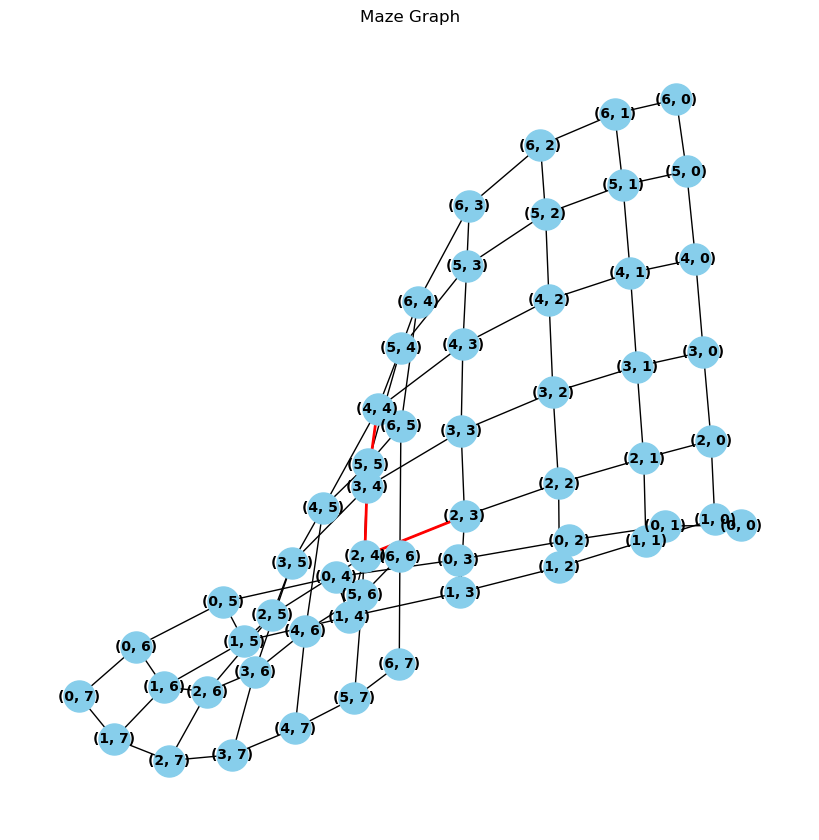

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the MazeGraph class
class MazeGraph:
    def __init__(self, maze):
        self.edges = self.generate_edges(maze)

    def generate_edges(self, maze):
        edges = {}
        rows, cols = len(maze), len(maze[0])
        for i in range(rows):
            for j in range(cols):
                if maze[i][j] != '1':  # Ignore walls
                    node = (i, j)
                    neighbors = []
                    # Check neighboring cells
                    if i > 0 and maze[i - 1][j] != '1':
                        neighbors.append(((i - 1, j), 1))  # Assuming unit cost for edges
                    if i < rows - 1 and maze[i + 1][j] != '1':
                        neighbors.append(((i + 1, j), 1))
                    if j > 0 and maze[i][j - 1] != '1':
                        neighbors.append(((i, j - 1), 1))
                    if j < cols - 1 and maze[i][j + 1] != '1':
                        neighbors.append(((i, j + 1), 1))
                    edges[node] = neighbors
        return edges

    def all_edges(self):
        return self.edges

# Define the function to display the graph
def showBinaryMazeGraph(mazeGraph, path=None):
    ''' Display a graph using networkx
        Input : MazeGraph from 2D maze, path (optional) - list of nodes representing the path
        Output : Input graph displayed
    '''
    edgeDict = mazeGraph.all_edges()
    edgeList = []

    # Flatten the edge dictionary into a list of edges
    for node, neighbors in edgeDict.items():
        for neighbor, weight in neighbors:
            edgeList.append((node, neighbor, {'weight': weight}))

    # Create a directed graph
    G = nx.Graph()
    G.add_edges_from(edgeList)

    # Draw the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Layout the nodes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)

    # Highlight the path if provided
    if path:
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.title('Maze Graph')
    plt.show()

# Function for Greedy Search
def greedy_search(graph, start, goal, heuristic):
    queue = [(heuristic(start, goal), start, [start])]
    while queue:
        (_, node, path) = queue.pop(0)
        if node == goal:
            return path
        for next_node, _ in graph[node]:
            if next_node not in path:
                new_path = path + [next_node]
                queue.append((heuristic(next_node, goal), next_node, new_path))
                # Sort the queue based on heuristic value
                queue.sort()
    return None

# Define a heuristic function (Manhattan distance)
def heuristic(node, goal):
    return abs(node[0] - goal[0]) + abs(node[1] - goal[1])

# Define the maze
maze = [['1', '1', '1', '1', '1', '1', '1', '1'],
        ['1', '4', '4', '4', '0', '1', '1', '1'],
        ['1', '0', '3', '2', '3', '0', '1', '1'],
        ['1', '1', '0', '1', '1', '0', '0', '1'],
        ['0', '1', '0', '0', '3', '0', '0', '1'],
        ['0', '1', '0', '0', '1', '0', '0', '1'],
        ['0', '1', '1', '1', '1', '1', '1', '1']]

# Convert maze to integers
maze = [[int(cell) for cell in row] for row in maze]

# Find the starting position
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 2:
            start_node = (i, j)
            break

# Find the goal position
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 3:
            goal_node = (i, j)
            break

 # Define a heuristic function (Manhattan distance)
def heuristic(node, goal):
    return abs(node[0] - goal[0]) + abs(node[1] - goal[1])

# Perform Greedy Search from start to goal with the defined heuristic
path = greedy_search(mazeGraph.edges, start_node, goal_node, heuristic)
           
            
# Create a MazeGraph instance
mazeGraph = MazeGraph(maze)


# Display the maze graph with BFS path
showBinaryMazeGraph(mazeGraph, path)


In [18]:
def calculate_path_cost(path):
    # Since Greedy Search is uninformed, each step has a cost of 1
    return len(path) - 1

# Calculate the cost of the Greedy Search path
cost_of_path = calculate_path_cost(path)
print("Cost of the path obtained from Greedy Search:", cost_of_path)


Cost of the path obtained from Greedy Search: 3


# A* Search

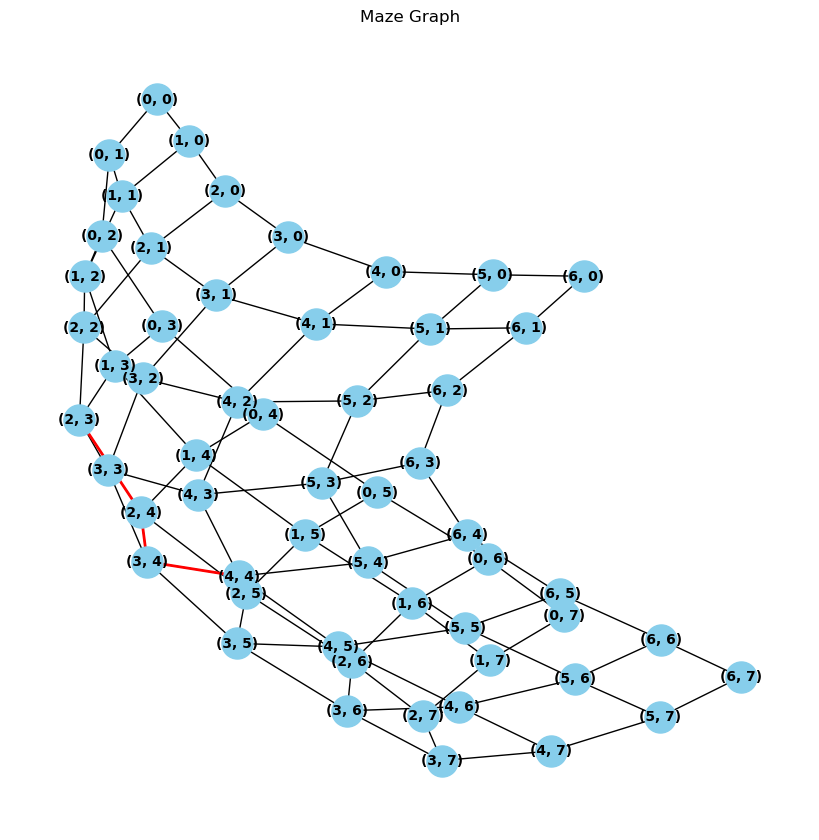

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the MazeGraph class
class MazeGraph:
    def __init__(self, maze):
        self.edges = self.generate_edges(maze)

    def generate_edges(self, maze):
        edges = {}
        rows, cols = len(maze), len(maze[0])
        for i in range(rows):
            for j in range(cols):
                if maze[i][j] != '1':  # Ignore walls
                    node = (i, j)
                    neighbors = []
                    # Check neighboring cells
                    if i > 0 and maze[i - 1][j] != '1':
                        neighbors.append(((i - 1, j), 1))  # Assuming unit cost for edges
                    if i < rows - 1 and maze[i + 1][j] != '1':
                        neighbors.append(((i + 1, j), 1))
                    if j > 0 and maze[i][j - 1] != '1':
                        neighbors.append(((i, j - 1), 1))
                    if j < cols - 1 and maze[i][j + 1] != '1':
                        neighbors.append(((i, j + 1), 1))
                    edges[node] = neighbors
        return edges

    def all_edges(self):
        return self.edges

# Define the function to display the graph
def showBinaryMazeGraph(mazeGraph, path=None):
    ''' Display a graph using networkx
        Input : MazeGraph from 2D maze, path (optional) - list of nodes representing the path
        Output : Input graph displayed
    '''
    edgeDict = mazeGraph.all_edges()
    edgeList = []

    # Flatten the edge dictionary into a list of edges
    for node, neighbors in edgeDict.items():
        for neighbor, weight in neighbors:
            edgeList.append((node, neighbor, {'weight': weight}))

    # Create a directed graph
    G = nx.Graph()
    G.add_edges_from(edgeList)

    # Draw the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Layout the nodes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)

    # Highlight the path if provided
    if path:
        path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.title('Maze Graph')
    plt.show()

# Function for A* search
def a_star_search(graph, start, goal, heuristic):
    queue = [(heuristic(start, goal), 0, start, [start])]
    visited = set()
    while queue:
        (_, cost, node, path) = queue.pop(0)
        if node == goal:
            return path
        if node not in visited:
            visited.add(node)
            for next_node, weight in graph[node]:
                if next_node not in path:
                    new_cost = cost + weight
                    new_path = path + [next_node]
                    queue.append((new_cost + heuristic(next_node, goal), new_cost, next_node, new_path))
                    # Sort the queue based on the sum of cost and heuristic value
                    queue.sort()
    return None

# Define a heuristic function (Manhattan distance)
def heuristic(node, goal):
    return abs(node[0] - goal[0]) + abs(node[1] - goal[1])

# Define the maze
maze = [['1', '1', '1', '1', '1', '1', '1', '1'],
        ['1', '4', '4', '4', '0', '1', '1', '1'],
        ['1', '0', '3', '2', '3', '0', '1', '1'],
        ['1', '1', '0', '1', '1', '0', '0', '1'],
        ['0', '1', '0', '0', '3', '0', '0', '1'],
        ['0', '1', '0', '0', '1', '0', '0', '1'],
        ['0', '1', '1', '1', '1', '1', '1', '1']]

# Convert maze to integers
maze = [[int(cell) for cell in row] for row in maze]

# Find the starting position
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 2:
            start_node = (i, j)
            break

# Find the goal position
for i in range(len(maze)):
    for j in range(len(maze[i])):
        if maze[i][j] == 3:
            goal_node = (i, j)
            break

# Create a MazeGraph instance
mazeGraph = MazeGraph(maze)

# Perform BFS from start to goal
path = a_star_search(mazeGraph.edges, start_node, goal_node, heuristic)

# Display the maze graph with BFS path
showBinaryMazeGraph(mazeGraph, path)



In [20]:
def calculate_path_cost(path, graph):
    total_cost = 0
    for i in range(len(path) - 1):
        current_node = path[i]
        next_node = path[i + 1]
        for neighbor, edge_cost in graph[current_node]:
            if neighbor == next_node:
                total_cost += edge_cost
                break
    return total_cost

# Calculate the cost of the A* search path
cost_of_path = calculate_path_cost(path, mazeGraph.edges)
print("Cost of the path obtained from A* search:", cost_of_path)


Cost of the path obtained from A* search: 3


## Conclusion
cost of BFS: 6
cost of DFS: 36
cost of DLS: unable to compute due to the depth limit
cost of IDS: 3
cost of UCS: 3
cost of Greedy: 3
cost of A*: 3

The best search algorithm is A* as it is a combination of greedy and UCS. UCS may be optimal and complete, but can be very 
inefficient, while greedy is neither optimal nor complete, but cuts search space considerably. With a good heuristic, significant savings is possible compared to uninformed search methods. Since iterative deepening search is an uninformed search method, A* is also better than iterative deepning search. Thus, it is the best search algorithm for our game, Sokoban.
